In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

from hyperopt import fmin, hp, tpe, Trials

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
train = pd.read_json('train_data.json.gz')
test = pd.read_json('test_data.json.gz')

In [3]:
train.columns

Index(['vid_caption', 'duration', 'width', 'height', 'fps', 'vcodec', 'vbr',
       'acodec', 'abr', 'thumb_width', 'thumb_height', 'pca_metricun',
       'vid_name_chars', 'vid_name_words', 'desc_chars', 'desc_words',
       'subtitle_chars', 'subtitle_words', 'subtitle_words_unique',
       'has_profanity', 'has_music', 'has_links', 'link_perc', 'pca_0',
       'pca_1', 'pca_2', 'pca_3', 'pca_4', 'Education', 'Entertainment',
       'Film & Animation', 'Howto & Style', 'News & Politics',
       'People & Blogs', 'Travel & Events', 'other_category', 'num_tags',
       'num_emoji_in_tags'],
      dtype='object')

In [4]:
X_train, y_train = train.drop('pca_metricun', axis=1), train['pca_metricun']
X_test, y_test = test.drop('pca_metricun', axis=1), test['pca_metricun']

In [5]:
def plot_feature_importance(X, y):
    rf_mod = RandomForestRegressor(n_jobs=-1)
    rf_mod.fit(X, y)
    feature_importance = rf_mod.feature_importances_
    feats = pd.DataFrame(zip(X.columns, feature_importance), columns=['feature', 'importance'])
    feats = feats.sort_values('importance', ascending=False)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feats, color='lightblue', ax=ax)
    ax.set_title('Feature Importance')

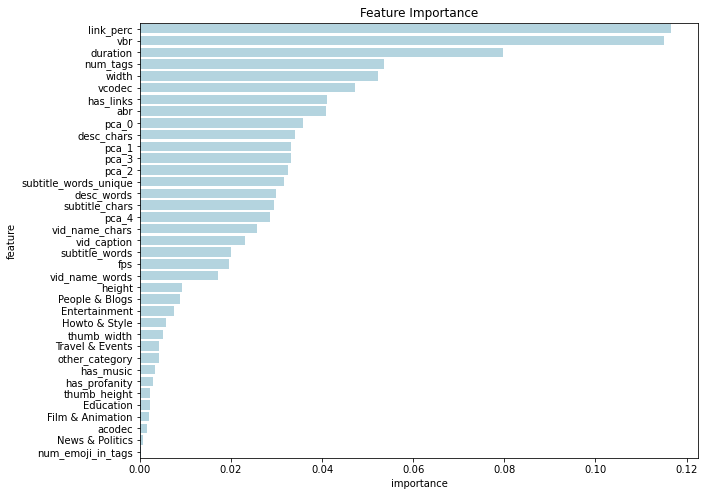

In [6]:
plot_feature_importance(X_train, y_train)

In [7]:
def score_model(model, X_train, y_train, folds:int=5, scoring:str='neg_root_mean_squared_error', 
                pipe_parts:list=[('scaler', StandardScaler()),]):
    
    if pipe_parts is not None:
        model = Pipeline(pipe_parts + [('model', model),])
    
    cv = KFold(n_splits=folds, shuffle=True)

    results = -cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

    return np.mean(results), np.std(results)

In [8]:
# untuned comparison
lr_model = LinearRegression()
score_model(lr_model, X_train, y_train)

(3.7715514789854225, 0.02854130252743839)

In [9]:
# SGDRegressor

sgd_param_grid = {'l1_ratio': hp.uniform('l1_ratio', 0, 1),
                  'learning_rate': hp.choice(
                      'learning_rate', [{
                          'type': 'optimal',
                          'alpha': hp.lognormal('alpha', 0, .5)
                      },
                      {
                          'type': 'invscaling',
                          'power_t': hp.normal('power_t', 0, 1)
                      }]
                  ),
                  'eta0': hp.lognormal('eta0', 0, 1)}

def sgd_objective(search_space):
    # im setting the loss function to 'huber' loss as other losses create a 
    # logistic regression and linear svm model while others are for regression. 
    # modified_huber is also robust to outliers
    l1_ratio = search_space['l1_ratio']
    learning_rate = search_space['learning_rate']['type']
    eta0 = search_space['eta0']
    if 'alpha' in search_space['learning_rate']:
        learning_param = search_space['learning_rate']['alpha']
        sgd_model = SGDRegressor(loss='huber', 
                                  penalty='elasticnet', 
                                  l1_ratio=l1_ratio,
                                  learning_rate=learning_rate,
                                  alpha=learning_param,
                                  eta0=eta0)
    else:
        learning_param = search_space['learning_rate']['power_t']
        sgd_model = SGDRegressor(loss='huber', 
                                  penalty='elasticnet', 
                                  l1_ratio=l1_ratio,
                                  learning_rate=learning_rate,
                                  power_t=learning_param,
                                  eta0=eta0)


    score, _ = score_model(sgd_model, X_train, y_train)
    return np.mean(score)

In [10]:
trials = Trials()
max_evals = 500
sgd_best_params = fmin(fn=sgd_objective, space=sgd_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
sgd_best_params

100%|██████████| 500/500 [04:36<00:00,  1.81trial/s, best loss: 3.799094304238198] 


{'eta0': 4.3561767476078055,
 'l1_ratio': 0.6067220529926147,
 'learning_rate': 1,
 'power_t': 0.5907427368693876}

In [11]:
l1_ratio = sgd_best_params['l1_ratio']
learning_rate = 'optimal' if sgd_best_params['learning_rate'] == 0 else 'invscaling'
eta0 = sgd_best_params['eta0']

if 'alpha' in sgd_best_params.keys():
    best_sgd_model = SGDRegressor(loss='huber', 
                                penalty='elasticnet', 
                                l1_ratio=l1_ratio,
                                learning_rate=learning_rate,
                                alpha=sgd_best_params['alpha'],
                                eta0=eta0)
else:
    best_sgd_model = SGDRegressor(loss='huber', 
                                penalty='elasticnet', 
                                l1_ratio=l1_ratio,
                                learning_rate=learning_rate,
                                power_t=sgd_best_params['power_t'],
                                eta0=eta0)

In [12]:
# LGBM

lgbm_param_grid = {'reg_alpha': hp.lognormal('reg_alpha', 0, .5),
                   'reg_lambda': hp.lognormal('reg_lambda', 0, .5),
                   'subsample': hp.uniform('subsample', 0, 1),
                   'num_leaves': hp.quniform('num_leaves', 10, 100, 1),
                   'max_depth': hp.quniform('max_depth', 1, 10, 1),
                   'n_estimators': hp.quniform('n_estimators', 50, 100, 1),
                   'learning_rate': hp.loguniform('learning_rate', -3, 0)}

def lgbm_objective(search_space):
    reg_alpha = search_space['reg_alpha']
    reg_lambda = search_space['reg_lambda']
    subsample = search_space['subsample']
    num_leaves = search_space['num_leaves']
    max_depth = search_space['max_depth']
    n_estimators = search_space['n_estimators']
    learning_rate = search_space['learning_rate']
    
    lgbm_model = LGBMRegressor(reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                subsample=subsample,
                                num_leaves=int(num_leaves),
                                max_depth=int(max_depth),
                                n_estimators=int(n_estimators),
                                learning_rate=learning_rate,
                                n_jobs=-1)

    score, _ = score_model(lgbm_model, X_train, y_train)
    return np.mean(score)

In [13]:
trials = Trials()
max_evals = 500
lgbm_best_params = fmin(fn=lgbm_objective, space=lgbm_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
lgbm_best_params

100%|██████████| 500/500 [11:52<00:00,  1.43s/trial, best loss: 2.8108524672598265]


{'learning_rate': 0.16118136312463385,
 'max_depth': 10.0,
 'n_estimators': 98.0,
 'num_leaves': 100.0,
 'reg_alpha': 1.3518492217280091,
 'reg_lambda': 0.022553363162134618,
 'subsample': 0.8159262258290716}

In [14]:
reg_alpha = lgbm_best_params['reg_alpha']
reg_lambda = lgbm_best_params['reg_lambda']
subsample = lgbm_best_params['subsample']
num_leaves = lgbm_best_params['num_leaves']
max_depth = lgbm_best_params['max_depth']
n_estimators = lgbm_best_params['n_estimators']
learning_rate = lgbm_best_params['learning_rate']

best_lgbm_model = LGBMRegressor(reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            subsample=subsample,
                            num_leaves=int(num_leaves),
                            max_depth=int(max_depth),
                            n_estimators=int(n_estimators),
                            learning_rate=learning_rate,
                            n_jobs=-1)

In [15]:
rf_param_grid = {'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
                 'max_depth': hp.quniform('max_depth', 2, 20, 1),
                 'max_features': hp.choice('max_features', ['auto', 'sqrt']),
                 'min_samples_split': hp.quniform('min_samples_split', 2, 5, 1),
                 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)}

def rf_objective(search_space):
    n_estimators = search_space['n_estimators']
    max_depth = search_space['max_depth']
    max_features = search_space['max_features']
    min_samples_split = search_space['min_samples_split']
    min_samples_leaf = search_space['min_samples_leaf']

    rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                      max_depth=int(max_depth),
                                      max_features=max_features,
                                      min_samples_split=int(min_samples_split),
                                      min_samples_leaf=int(min_samples_leaf),
                                      n_jobs=-1)

    score, _ = score_model(rf_model, X_train, y_train)
    return np.mean(score)

In [16]:
trials = Trials()
max_evals = 10
rf_best_params = fmin(fn=rf_objective, space=rf_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
rf_best_params

100%|██████████| 10/10 [02:23<00:00, 14.35s/trial, best loss: 2.859720428332733]


{'max_depth': 17.0,
 'max_features': 0,
 'min_samples_leaf': 3.0,
 'min_samples_split': 3.0,
 'n_estimators': 384.0}

In [17]:
n_estimators = rf_best_params['n_estimators']
max_depth = rf_best_params['max_depth']
max_features = 'auto' if rf_best_params['max_features'] == 0 else 'sqrt'
min_samples_split = rf_best_params['min_samples_split']
min_samples_leaf = rf_best_params['min_samples_leaf']

best_rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                    max_depth=int(max_depth),
                                    max_features=max_features,
                                    min_samples_split=int(min_samples_split),
                                    min_samples_leaf=int(min_samples_leaf),
                                    n_jobs=-1)

In [18]:
# adaboost
ada_param_grid = {'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
                  'max_depth': hp.quniform('max_depth', 1, 3, 1),
                  'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                  'learning_rate': hp.lognormal('learning_rate', 0, 1)}

def ada_objective(search_space):
    n_estimators = search_space['n_estimators']
    max_depth = search_space['max_depth']
    min_samples_split = search_space['min_samples_split']
    learning_rate = search_space['learning_rate']

    ada_model = AdaBoostRegressor(n_estimators=int(n_estimators),
                                   learning_rate=learning_rate,
                                   base_estimator=DecisionTreeRegressor(max_depth=int(max_depth),
                                                                         min_samples_split=int(min_samples_split)))

    score, _ = score_model(ada_model, X_train, y_train)
    return np.mean(score)

In [19]:
trials = Trials()
max_evals = 10
ada_best_params = fmin(fn=ada_objective, space=ada_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
ada_best_params

100%|██████████| 10/10 [00:44<00:00,  4.48s/trial, best loss: 3.73197950754967] 


{'learning_rate': 0.5719334633874693,
 'max_depth': 3.0,
 'min_samples_split': 4.0,
 'n_estimators': 105.0}

In [20]:
n_estimators = ada_best_params['n_estimators']
max_depth = ada_best_params['max_depth']
min_samples_split = ada_best_params['min_samples_split']
learning_rate = ada_best_params['learning_rate']

best_ada_model = AdaBoostRegressor(n_estimators=int(n_estimators),
                                learning_rate=learning_rate,
                                base_estimator=DecisionTreeRegressor(max_depth=int(max_depth),
                                                                        min_samples_split=int(min_samples_split)))

In [21]:
stacking_model = StackingRegressor(estimators=[('SGDRegressor', best_sgd_model),
                                               ('LGBMRegressor', best_lgbm_model),
                                               ('RandomForestRegressor', best_rf_model),
                                               ('AdaBoostRegressor', best_ada_model)],
                                                n_jobs=-1)

In [22]:
score_model(stacking_model, X_train, y_train)

(2.7696463653575156, 0.026089535492071787)

In [23]:
# mean of cnn and ensemble model
def mean_model_outputs(scores_series:pd.Series, cnn_scores_series:pd.Series):
    scores = scores_series.merge(cnn_scores_series, right_index=True, left_index=True)
    scores = scores.sum(axis=1)
    return scores

In [31]:
   
def resid_qq(y_test, predicted, ax):
    resids = y_test - predicted
    probplot(resids, plot=ax)
    ax.set_title('Q-Q normal plot')
    ax.set_ylabel('Sample Quantiles')
    ax.set_xlabel('Theoretical Quantiles')
    
def resid_plot(y_test, predictions, ax):
    resids = y_test - predictions
    sns.regplot(x=predictions, y=resids, ax=ax, fit_reg=False)
    ax.axhline(0, color='k')
    ax.set_title('Residuals vs. predicted values')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residuals')

def plot_er_hist(y_test, predicted, ax, bins=30):
    resids = y_test - predicted
    sns.distplot(resids, bins=bins, ax=ax)
    ax.set_title('Histogram of the Residuals')
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Count")
    
def final_test(mod, X_train, y_train, X_test, y_test):
    mod = Pipeline([('scaler', StandardScaler()), ('model', mod),])
    mod = clone(mod)
    mod.fit(X_train, y_train)
    preds = mod.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f"{mod.named_steps['model'].__class__.__name__}\nRMSE: {rmse:1.6f}, MAE:{mae:1.6f} $r^2$:{r2:1.6f}", fontsize=18, y=1.1)
    resid_plot(y_test, preds, ax[0])
    plot_er_hist(y_test, preds, ax[1])
    resid_qq(y_test, preds, ax[2])
    plt.tight_layout()

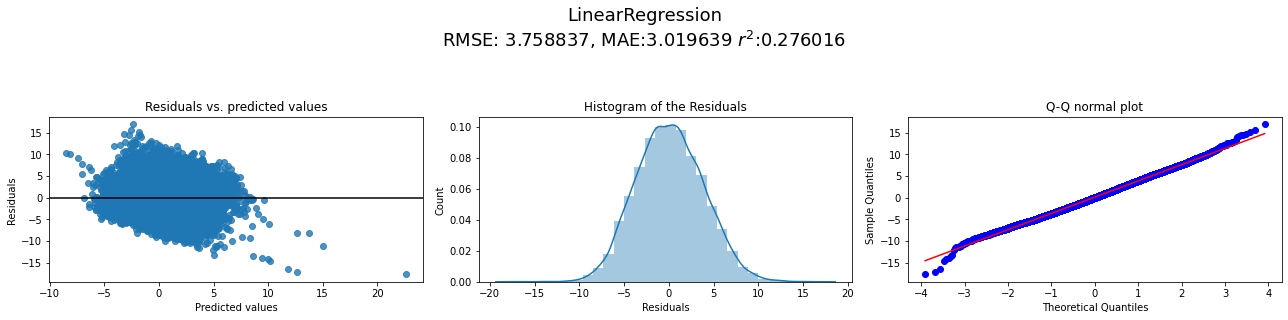

In [32]:
final_test(LinearRegression(), X_train, y_train, X_test, y_test)

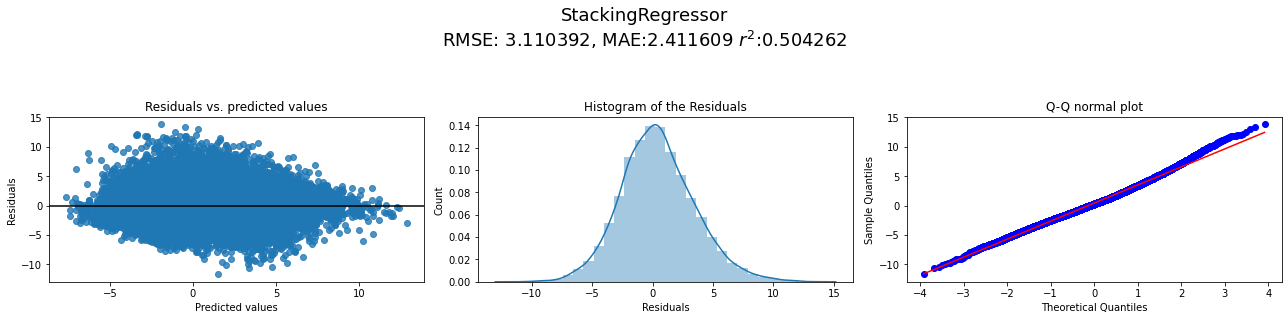

In [33]:
final_test(stacking_model, X_train, y_train, X_test, y_test)